<a href="https://colab.research.google.com/github/7aslan/Diagnosis_Of_Pneumonia/blob/main/Diagnosis_Of_Pneumonia_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kaggle


In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:19<00:00, 191MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s]


In [9]:
#Unzip the downloaded data
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip","r")
zip_ref.extractall()
zip_ref.close()

In [10]:
# Lets look at that how many images are in each folder
import os
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'chest_xray'.
There are 3 directories and 1 images in 'chest_xray/chest_xray'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/train'.
There are 0 directories and 1342 images in 'chest_xray/chest_xray/train/NORMAL'.
There are 0 directories and 3876 images in 'chest_xray/chest_xray/train/PNEUMONIA'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/NORMAL'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/PNEUMONIA'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/test'.
There are 0 directories and 234 images in 'chest_xray/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in 'chest_xray/chest_xray/test/PNEUMONIA'.
There are 1 directories and 1 images in 'chest_xray/__MACOSX'.
There are 3 directories and 3 images in 'chest_xray/__MACOSX/chest_xray'.
There are 2 directories and 3 images in 'chest_xray/_

We have lots of files in this dataset. But I am gonna focus on chest_xray files.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  target_folder= target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (1384, 1800)


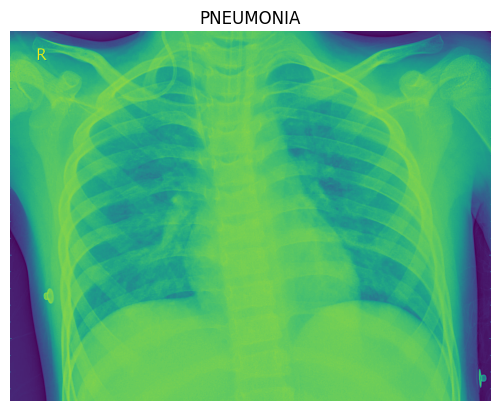

In [12]:
img=view_random_image(target_dir="/content/chest_xray/chest_xray/train/", target_class="PNEUMONIA")

In [13]:
img

array([[79, 79, 79, ...,  4,  3,  4],
       [80, 81, 81, ...,  2,  2,  1],
       [81, 82, 84, ...,  2,  1,  0],
       ...,
       [27, 27, 27, ..., 17, 16, 15],
       [27, 27, 27, ..., 17, 16, 15],
       [27, 27, 27, ..., 18, 16, 15]], dtype=uint8)

#Pre-processing Data
Lets prepare our dataset i am gonna use ImageDataGenerators class along with flow_from_directory method . I am planning to use data augmentation which will be compund on the Neural network architecture.

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
val_datagen = ImageDataGenerator(rescale = 1/255.)


print("Training Images : ")

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")
print("Test Images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="binary")
print("Validation Images : ")
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size = IMAGE_SHAPE,
                                           batch_size = BATCH_SIZE,
                                           class_mode="binary")


Training Images : 
Found 5216 images belonging to 2 classes.
Test Images : 
Found 624 images belonging to 2 classes.
Validation Images : 
Found 16 images belonging to 2 classes.


Let's use callbacks. I  am gonna cerate a callback function to use later.

In [39]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to : {log_dir}")
  return tensorboard_callback

Everything looks fine . Lets try to create our model with transfer learning using one of the pre-trained model I pick

In [72]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [41]:
# I picked efficient net V2 , anf then I am gonna fine tune the model
efficient_net_url = "https://tfhub.dev/google/efficientnet/b2/feature-vector/1"

In [42]:
def create_model(model_url, num_classes=1):
  # Download the pretrained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name= "feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Flatten(),
      layers.Dense(1, activation="sigmoid", name="output_layer")
  ])

  return model

Now Lets create and compile our model

In [37]:
# Create model
efficient_model=create_model(efficient_net_url, num_classes=train_data.num_classes)

#Compile
efficient_model.compile(loss="binary_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])


ValueError: ignored

In [ ]:
efficient_model.summary()

In [ ]:
# Fit the model
efficient_history = efficient_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps = len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="efficient_net_xray")])


I trained the model in 5 epochs to not lose time a lot at the beginning of the project. It seems that we got an overfitting problem ! Lets visualize the accuracy and loss graphs:

In [22]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs =  range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss , label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


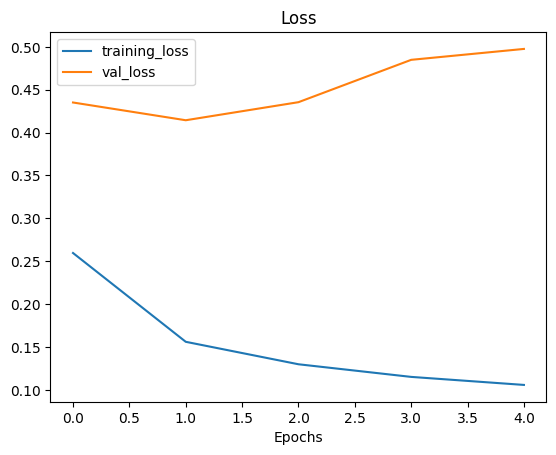

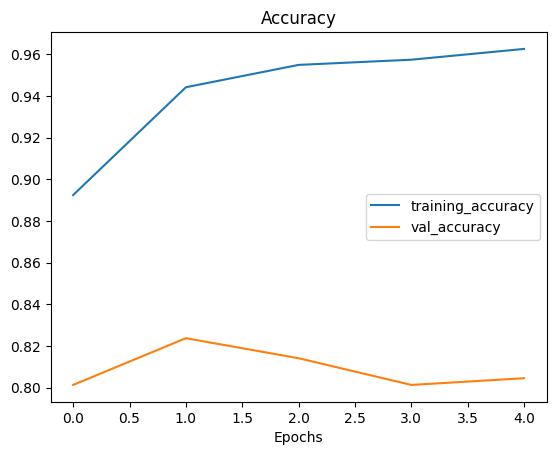

In [23]:
plot_loss_curves(efficient_history)

In [24]:
#LEts evaluate the model
eval_model = efficient_model.evaluate(test_data)

20/20 [==============================] - 6s 296ms/step - loss: 0.4975 - accuracy: 0.8045


I guess , i should optimize my model because of overfitting problem. I think my model was so complicated compared to data . This is my first impression. So that , I am gonna change the model and use data augmentation . And I  am also gonna use GlobalAveragePooling2D layer to reduce computation . If it works , thats gonna be good. If it doesnt , i am gonna use data augmentation as a layer into the my model. After the using feature vector method. I may apply fine tuning .




Lets start with data augmentation and add GloabalAveragePooling2D layer to reduce computation


In [28]:
data_augmentation  = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name="data_augmentation")

In [74]:
# Lets start fine tuning operations:
input_shape=(256,256,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

#Freeze the base model
base_model.trainable=False

model = Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.45, seed= 123),
    tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2d")
])

#Compile the model
model_0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=len(test_data),
                              callbacks=[create_tensorboard_callback("transfer_learning_model_0" , "Opt._with_aug_and_gap" )])


Saving Tensorboard log files to : transfer_learning_model_0/Opt._with_aug_and_gap/20230822-015559


Epoch 1/5
163/163 [==============================] - 76s 412ms/step - loss: 0.4523 - accuracy: 0.7814 - val_loss: 0.7376 - val_accuracy: 0.6266
Epoch 2/5
163/163 [==============================] - 66s 408ms/step - loss: 0.4464 - accuracy: 0.7843 - val_loss: 1.0905 - val_accuracy: 0.6282
Epoch 3/5
163/163 [==============================] - 63s 388ms/step - loss: 0.4224 - accuracy: 0.7985 - val_loss: 0.8025 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 65s 398ms/step - loss: 0.4318 - accuracy: 0.7918 - val_loss: 0.9168 - val_accuracy: 0.6298
Epoch 5/5
163/163 [==============================] - 62s 378ms/step - loss: 0.4170 - accuracy: 0.8002 - val_loss: 0.8263 - val_accuracy: 0.6250


In [75]:
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, None)  0        
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 batch_normalization (BatchN  (None, None, None, 1280)  5120     
 ormalization)                                                   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                           

Woow , looks terrible , worse than previous model. Lets plot it

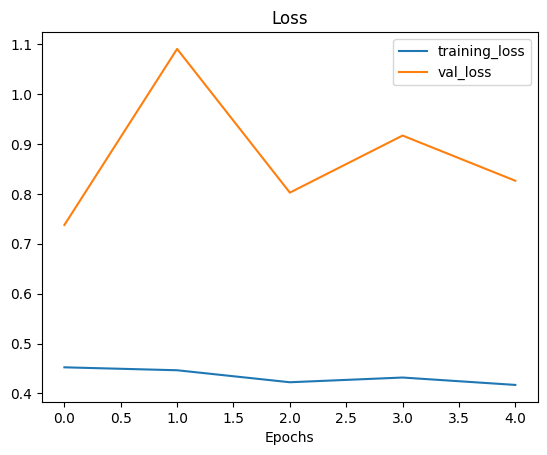

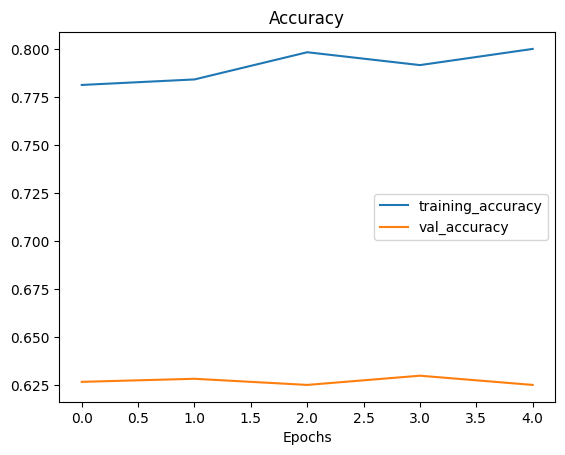

In [81]:
plot_loss_curves(history_model_0)

I have no clue about it. I have tried so much different things but it goes worse than first model I have created. I will look easier datasets , and develop more projects about transfer learning. and then take a look at this project again. For a while , i am gonna stop working on this project.